In [1]:
import tensorflow as tf
import shutil
import numpy as np
import tqdm
import pandas as pd
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
import cv2

GAMMA = 0.99
TAU = 0.01
BATCHSIZE = 128
N_BATCHES = 64
N_MULTI_ENVS = 62
EXPLORATION_RATE = 0.22
EPSILON_DECAY = 0.9999

N_NEW_SAMPLES = 500
N_SAMPLE_SETS = 100

CHECKPOINT_FREQ = 100
LOG_FREQ = 100
N_TEST_ENVS = 8
ENV_NAME = 'ALE/Breakout-v5'

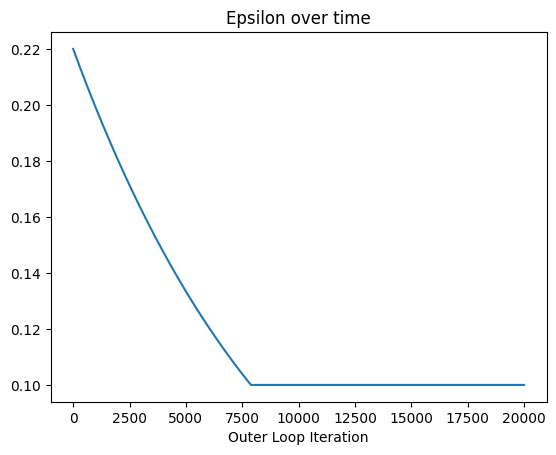

In [2]:
%matplotlib inline
x = np.arange(20000)
y = EXPLORATION_RATE * (EPSILON_DECAY ** x)
y = np.maximum(y, 0.1)

plt.plot(x,y)
plt.title("Epsilon over time")
plt.xlabel("Outer Loop Iteration")
plt.show()

In [3]:
TMP_SAVE_TO_PATH = "breakout/ckps/ckpt"
TMP_LOG_PATH = "breakout/logs/{}.json"
TB_LOGS = "breakout/tb_lobs/run"


os.makedirs(TMP_SAVE_TO_PATH.replace("/ckpt",""), exist_ok= True)
os.makedirs(TMP_LOG_PATH.replace("/{}.json",""), exist_ok= True)
os.makedirs(TB_LOGS, exist_ok= True)

# # get old checkpoint
# !cp /content/gdrive/MyDrive/DeepRL/HW4/checkpoint.zip checkpoint.zip
# !unzip -d {TMP_SAVE_TO_PATH} checkpoint.zip

LOSS = tf.keras.losses.Huber()
CNN_SHAPE = (84, 84)

In [4]:
def triple_conv_block_no_batchnorm(x, filters):

    x = tf.keras.layers.Conv2D(
        filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(
        filters, 3, padding='same', activation='relu')(x) + x
    x = tf.keras.layers.Conv2D(
        filters, 3, padding='same', activation='relu')(x) + x

    return x

def get_small_dqn():
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input((84, 84, 4,))
    x = triple_conv_block_no_batchnorm(inputs, 10)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = triple_conv_block_no_batchnorm(x, 20)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, "relu")(x)
    outputs = tf.keras.layers.Dense(4, "linear")(x)

    model = tf.keras.Model(inputs, outputs, name="standard_dqn")

    return model


@tf.function
def sample_trajectory(dqn, state, epsilon=0.2):

    n_par = tf.shape(state)[0]

    mask = tf.random.uniform((n_par,), 0, 1, tf.float32) > epsilon

    predictions = dqn(state, training=False)
    max_actions = tf.math.argmax(predictions, axis=-1)

    random_choices = tf.random.uniform(
        shape=[n_par], minval=0, maxval=4, dtype=tf.int64)

    return tf.where(mask, max_actions, random_choices), tf.reduce_max(predictions, -1)




def get_standard_dqn():
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input((84,84, 4))

    x = triple_conv_block_no_batchnorm(inputs, 16)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = triple_conv_block_no_batchnorm(x, 32)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = triple_conv_block_no_batchnorm(x, 64)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, "relu")(x)
    outputs = tf.keras.layers.Dense(4, "linear")(x)

    model = tf.keras.Model(inputs, outputs, name="standard_dqn")

    return model




In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

q_net = get_standard_dqn()

target_net = tf.keras.models.clone_model(q_net)

checkpoint = tf.train.Checkpoint(q_net = q_net, target_net = target_net, optimizer = optimizer)

writer = tf.summary.create_file_writer(TB_LOGS)

# restore
checkpoint.restore("breakout/ckps/ckpt-217")



2023-06-21 09:51:37.573129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 09:51:37.577374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 09:51:37.577541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 09:51:37.577832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
def process_frame(frame):

    frame = cv2.cvtColor(np.float32(frame), cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(
        frame, (84, 84), interpolation=cv2.INTER_AREA
    )
    return frame

In [28]:
def get_episodes(dqn, ):

        env = gym.make(ENV_NAME)
        
        current_state = env.reset()[0]
        frames = deque([process_frame(current_state) for _ in range(4)])
        
        renders = []
        current_lives = 6
        steps = 0
        rewards = 0
        
        while True:
        
            lives = env.unwrapped.ale.lives()
            
            if lives < current_lives:
                # fire
                action = 1
                current_lives  = lives
            else:
                
                frame_tensor = np.stack(list(frames), -1)
                frame_tensor = tf.convert_to_tensor(frame_tensor, dtype = tf.float32)[None, :]
                
                predictions = dqn(frame_tensor, training=False)
                action = tf.math.argmax(predictions, axis=-1)[0]
                
                
            observation, reward, terminated, truncated, info = env.step(action)
            
            rewards += reward
            renders.append(observation)
            
            if terminated:
                
                break
                
            obs = process_frame(observation)
                           
            frames.popleft()
            
            frames.append(obs)
            
            steps +=1
                
        
        return rewards, steps, renders

In [29]:
env = gym.make(ENV_NAME)

env.unwrapped.get_action_meanings()[1] == 'FIRE'

True

In [30]:
best_renders = None
highest_reward = 0


for i in range(30):
    
    print(i)
    
    rewards, steps, renders = get_episodes(q_net)
    print(rewards)
    if rewards > highest_reward:
        highest_reward = rewards
        best_renders = renders

0
144.0
1
104.0
2
319.0
3
97.0
4
261.0
5
301.0
6
127.0
7
70.0
8
312.0
9
195.0
10
136.0
11
167.0
12
124.0
13
112.0
14
81.0
15
109.0
16
132.0
17
70.0
18
94.0
19
284.0
20
94.0
21
80.0
22
314.0
23
101.0
24
68.0
25
292.0
26
271.0
27
55.0
28
121.0
29
88.0


In [32]:
episode = np.stack(best_renders)
episode.shape

(2111, 210, 160, 3)

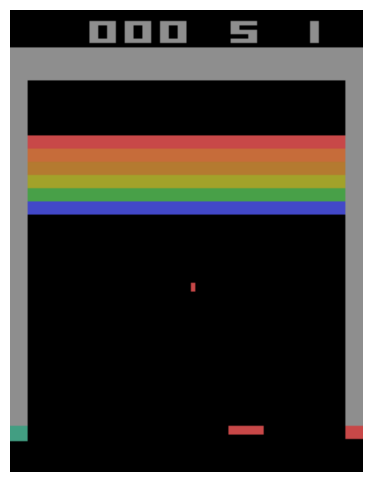

In [34]:
from matplotlib import animation

fig = plt.figure(figsize=(6,6))

steps = np.arange(len(episode))

im = plt.imshow(episode[0])
plt.axis('off')

def update(i):
    
    # ttl.set_text(
    #     f"Current Reward: {rewards[rounded]:.2f}",
    # )

    im.set_array(episode[i])
    return (im,)


ani = animation.FuncAnimation(fig, update, steps)

ani.save("breakout.mp4", savefig_kwargs={"facecolor": (1, 1, 1, 1)}, fps = 30)
ani.save("breakout.gif", savefig_kwargs={"facecolor": (1, 1, 1, 1)}, fps = 30)